### This code merges code Fig5_old to Fig2c_and_Selecting_peak and Fig4 to create the means


In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cosima_cookbook as cc
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45453,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:46267,Total threads: 4
Dashboard: /proxy/43927/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:42577,


## Creating the wind variables

In [2]:
#session_ryf = cc.database.create_session()
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))


### Prepare winds (taux)

In [3]:
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-256, -246)

windX_con = cc.querying.getvar(iaf_cycle3,'tau_x', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
windX_con = windX_con.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                            
windX_con = windX_con.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

### Prepare winds (tauy)

In [4]:
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-256, -246)

windY_con = cc.querying.getvar(iaf_cycle3,'tau_y', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
windY_con = windY_con.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                            
windY_con = windY_con.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

### Opening arrays that select the picks for low and high intrusion months

In [5]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [6]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

### creating the averages for peaks and lows

In [7]:
#full mean
windX_avg = windX_con.mean('time')
windY_avg = windY_con.mean('time')

#mean of all high peaks together
windX_high_avg = windX_con[top_id].mean('time')
windY_high_avg = windY_con[top_id].mean('time')

#mean of all low peaks together
windX_low_avg = windX_con[bt_id].mean('time')
windY_low_avg = windY_con[bt_id].mean('time')


### load the averages for picks and lows and time average

In [8]:
windX_avg = windX_avg.load()
windY_avg = windY_avg.load()

windX_high_avg = windX_high_avg.load()
windY_high_avg = windY_high_avg.load()

windX_low_avg = windX_low_avg.load()
windY_low_avg = windY_low_avg.load()

### Opening arrays that select the picks for low and high intrusion months AGAIN, to calculate a version with winds shifted 2 months prior

In [9]:
outpath = '/g/data/v45/ns3783/top_index_sh.nc'
profile_data = xr.open_dataset(outpath)
top_id_sh = profile_data.top_id_sh

In [10]:
outpath = '/g/data/v45/ns3783/bottom_index_sh.nc'
profile_data = xr.open_dataset(outpath)
bt_id_sh = profile_data.bt_id_sh

## So I have the small problem that, when I made this shifted array, the indexes shifted, but the time values didn't. What that means is that the code I use for top_id and bt_id doesn't work, because the time values don't match with the time values on windX_con and so on. The solution for this is to find the time values associated to the indexes in windX and then do the average that way, as per below.

In [11]:
# Map integer indices in top_id_sh to actual time values
time_values = windX_con.time[top_id_sh.values]

# Select using the actual time values and then average
selected_windX_con = windX_con.sel(time=time_values)
windX_high_avg_sh = selected_windX_con.mean(dim="time")

# Select using the actual time values and then average
selected_windY_con = windY_con.sel(time=time_values)
windY_high_avg_sh = selected_windY_con.mean(dim="time")

In [12]:
bt_id_sh.values

array([  1,   2,   3,  18,  19,  20,  21,  22,  23,  24,  43,  44,  46,
        47,  48,  50,  51,  52,  53,  68,  78,  79,  80,  81,  82,  83,
        84, 152, 153, 154, 163, 164, 165, 166, 174, 185, 186, 187, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 227, 228, 229,
       230, 233, 234, 235, 236, 246, 247, 248, 249, 250, 251, 253, 259,
       260, 262, 271, 313, 314, 315, 318, 319, 320, 321, 322, 325, 326,
       327, 332, 339, 343, 344, 345, 346, 379, 380, 381, 389, 390, 391,
       392, 437, 438, 439, 440, 441, 462, 463, 475, 487, 488, 492, 493,
       494, 495, 496, 497, 498, 499, 500, 510, 511, 512, 667, 668, 669,
       670, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 722,
       725, 726, 727, 728, 729])

In [13]:
# Map integer indices in top_id_sh to actual time values
time_values = windX_con.time[bt_id_sh.values]

# Select using the actual time values and then average
selected_windX_con = windX_con.sel(time=time_values)
windX_low_avg_sh = selected_windX_con.mean(dim="time")

# Select using the actual time values and then average
selected_windY_con = windY_con.sel(time=time_values)
windY_low_avg_sh = selected_windY_con.mean(dim="time")

### load the averages for picks and lows and time average

In [14]:
windX_high_avg_sh = windX_high_avg_sh.load()
windY_high_avg_sh = windY_high_avg_sh.load()

windX_low_avg_sh = windX_low_avg_sh.load()
windY_low_avg_sh = windY_low_avg_sh.load()

### Load bathymetry

In [15]:
#have to load this again
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

# import bathymetry and the land/ocean mask to add to plot:
hu = cc.querying.getvar(control,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(hu.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

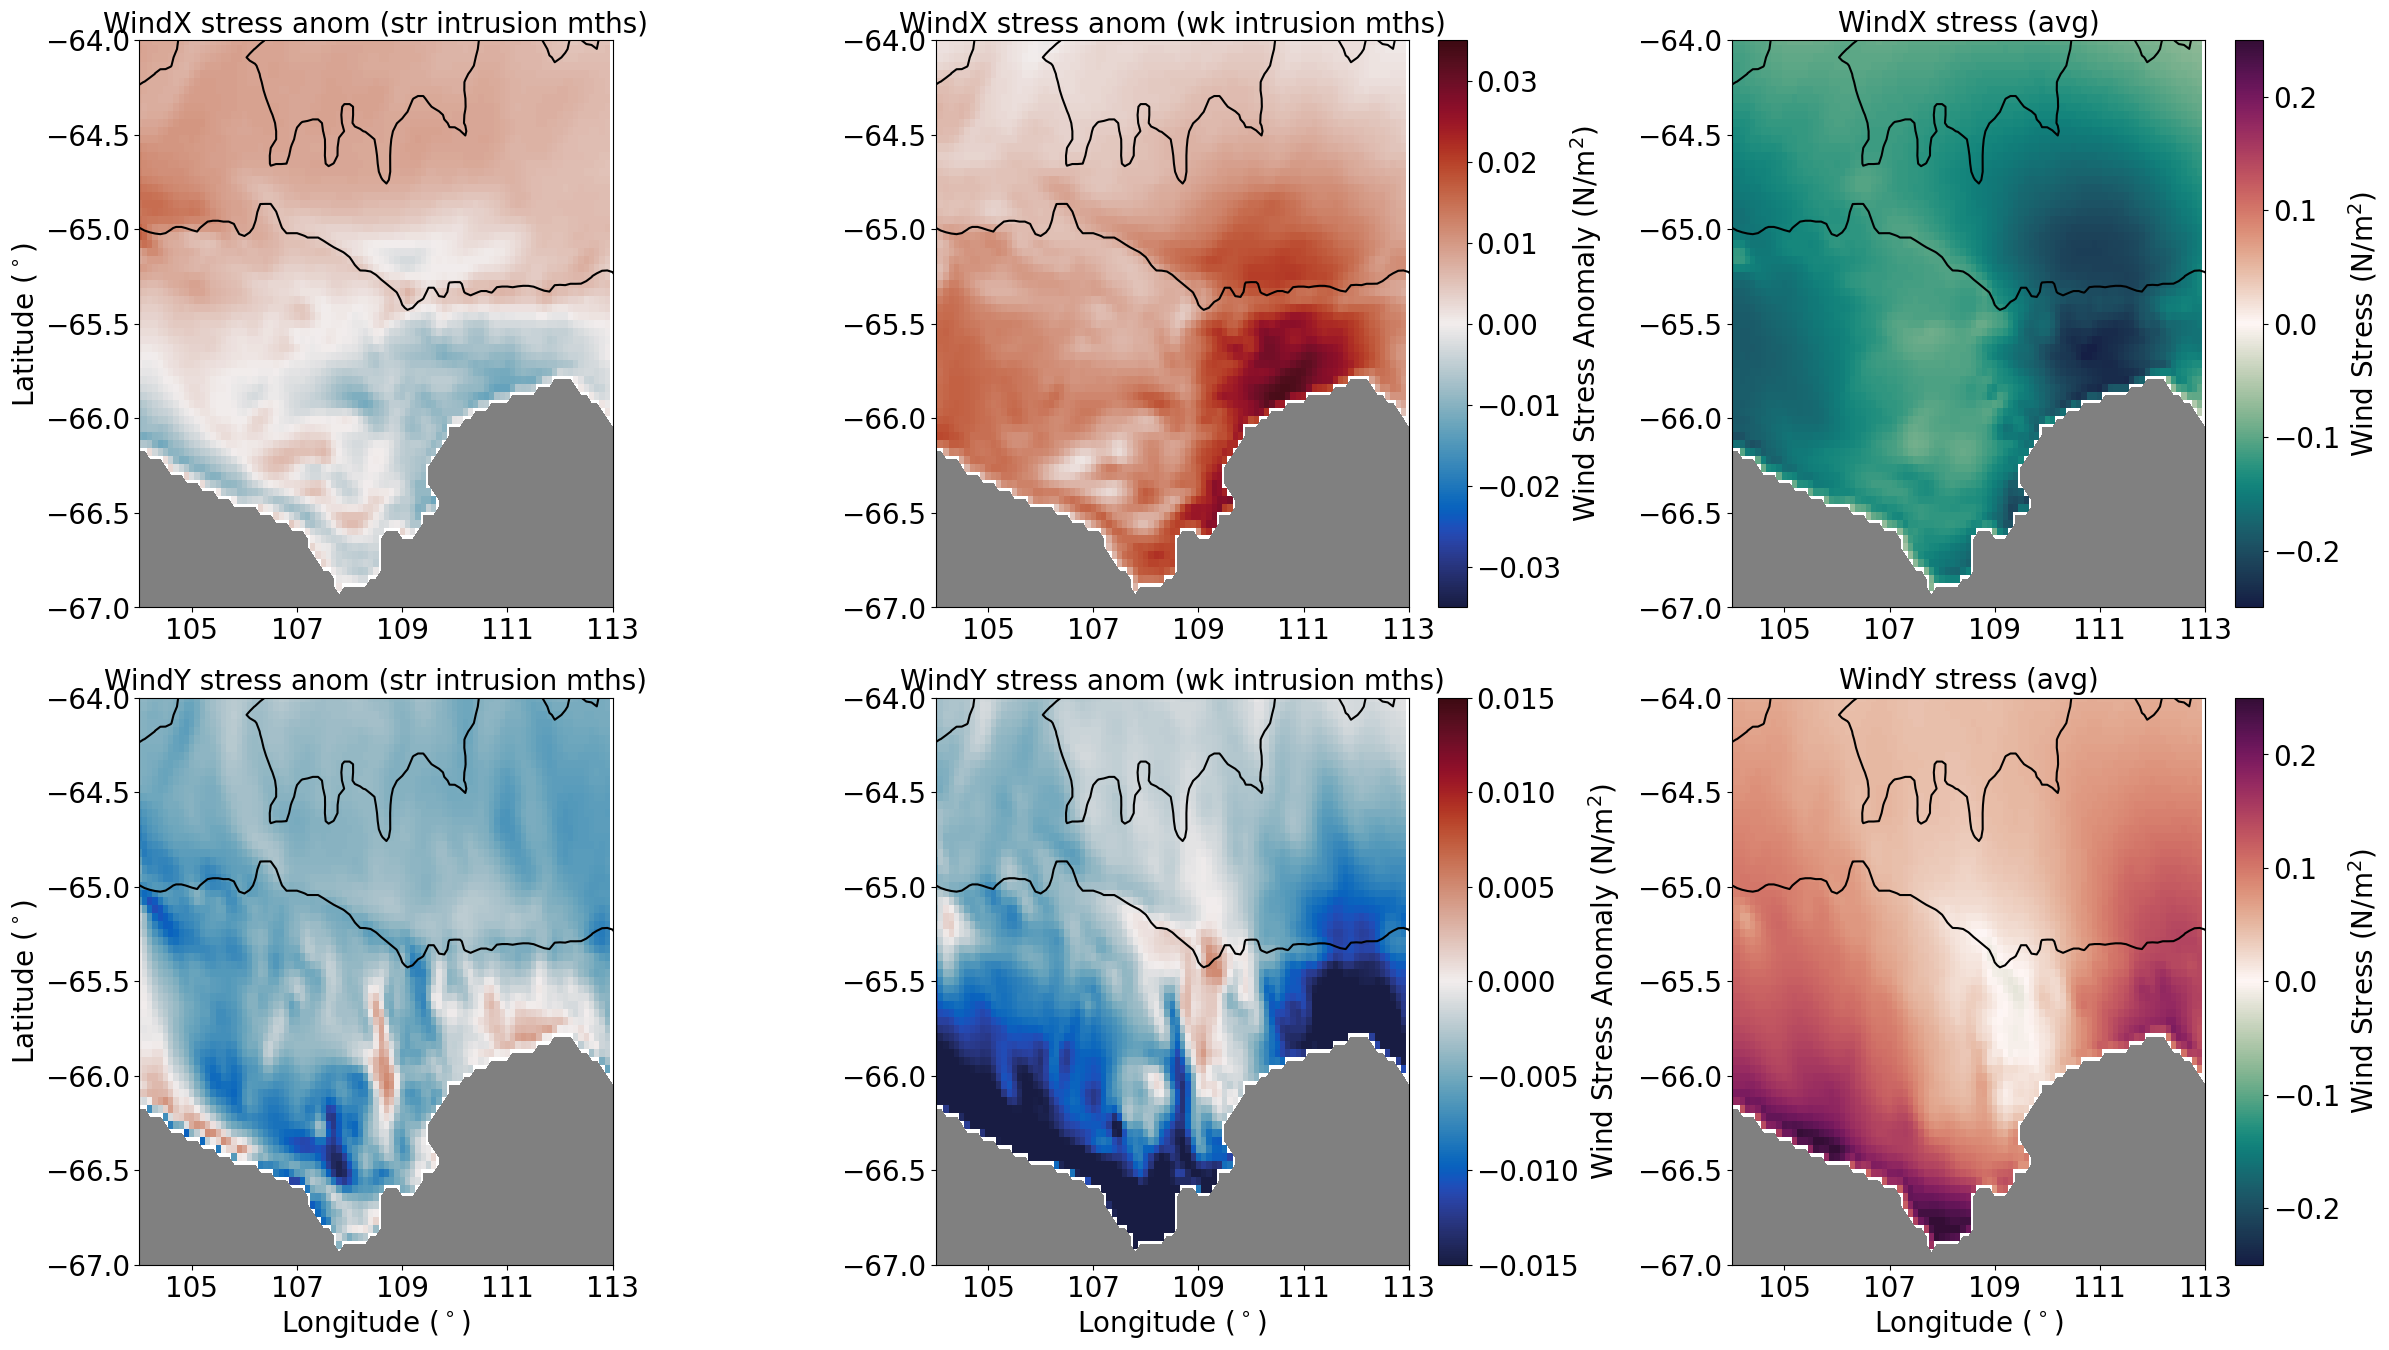

In [16]:
fontsize=20

fig=plt.figure(figsize=(24, 26))
fig.subplots_adjust(top=0.88)

wX_high = windX_high_avg-windX_avg;
wX_low = windX_low_avg-windX_avg;
wY_high = windY_high_avg-windY_avg;
wY_low = windY_low_avg-windY_avg;
ax0=plt.subplot(4,3,1) 
pc = plt.pcolormesh(wX_high.xu_ocean, wX_high.yu_ocean,wX_high,cmap = cmocean.cm.balance, 
                        vmin=-0.035,vmax=0.035)
plt.title('WindX stress anom (str intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
 # Add subplot indexes (a), b), c)) - first argument moves it horizontally, second argument moves it vertically
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0=plt.subplot(4,3,2) 
pc = plt.pcolormesh(wX_low.xu_ocean, wX_low.yu_ocean,wX_low,cmap = cmocean.cm.balance, 
                        vmin=-0.035,vmax=0.035)
plt.title('WindX stress anom (wk intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress Anomaly (N/m$^{2}$)', fontsize = 20,labelpad=5)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


ax0=plt.subplot(4,3,3)
pc = plt.pcolormesh(windX_avg.xu_ocean, windX_avg.yu_ocean,windX_avg,cmap = cmocean.cm.curl, 
                        vmin=-0.25,vmax=0.25) #ideal was -0.25 and 0.05
plt.title('WindX stress (avg)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress (N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,4) 
pc = plt.pcolormesh(wY_high.xu_ocean, wY_high.yu_ocean,wY_high,cmap = cmocean.cm.balance, 
                        vmin=-0.015,vmax=0.015) # ideal was -0.025 and 0.005
plt.title('WindY stress anom (str intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[6])

ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,5) 
pc = plt.pcolormesh(wY_low.xu_ocean, wY_low.yu_ocean,wY_low,cmap = cmocean.cm.balance, 
                        vmin=-0.015,vmax=0.015) # ideal was -0.025 and 0.005
plt.title('WindY stress anom (wk intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress Anomaly (N/m$^{2}$)', fontsize = 20,labelpad=5)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


ax0=plt.subplot(4,3,6) 
pc = plt.pcolormesh(windY_avg.xu_ocean, windY_avg.yu_ocean,windY_avg,cmap = cmocean.cm.curl, 
                        vmin=-0.25,vmax=0.25) #ideal was -0.05 and 0.25
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('WindY stress (avg)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress (N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

fig.tight_layout()

#save_results_to = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
#plt.savefig(save_results_to + 'WindStressAnom_fixed_limits.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

## Plot again shifting the wind 2 months previously like I do with Ekman 

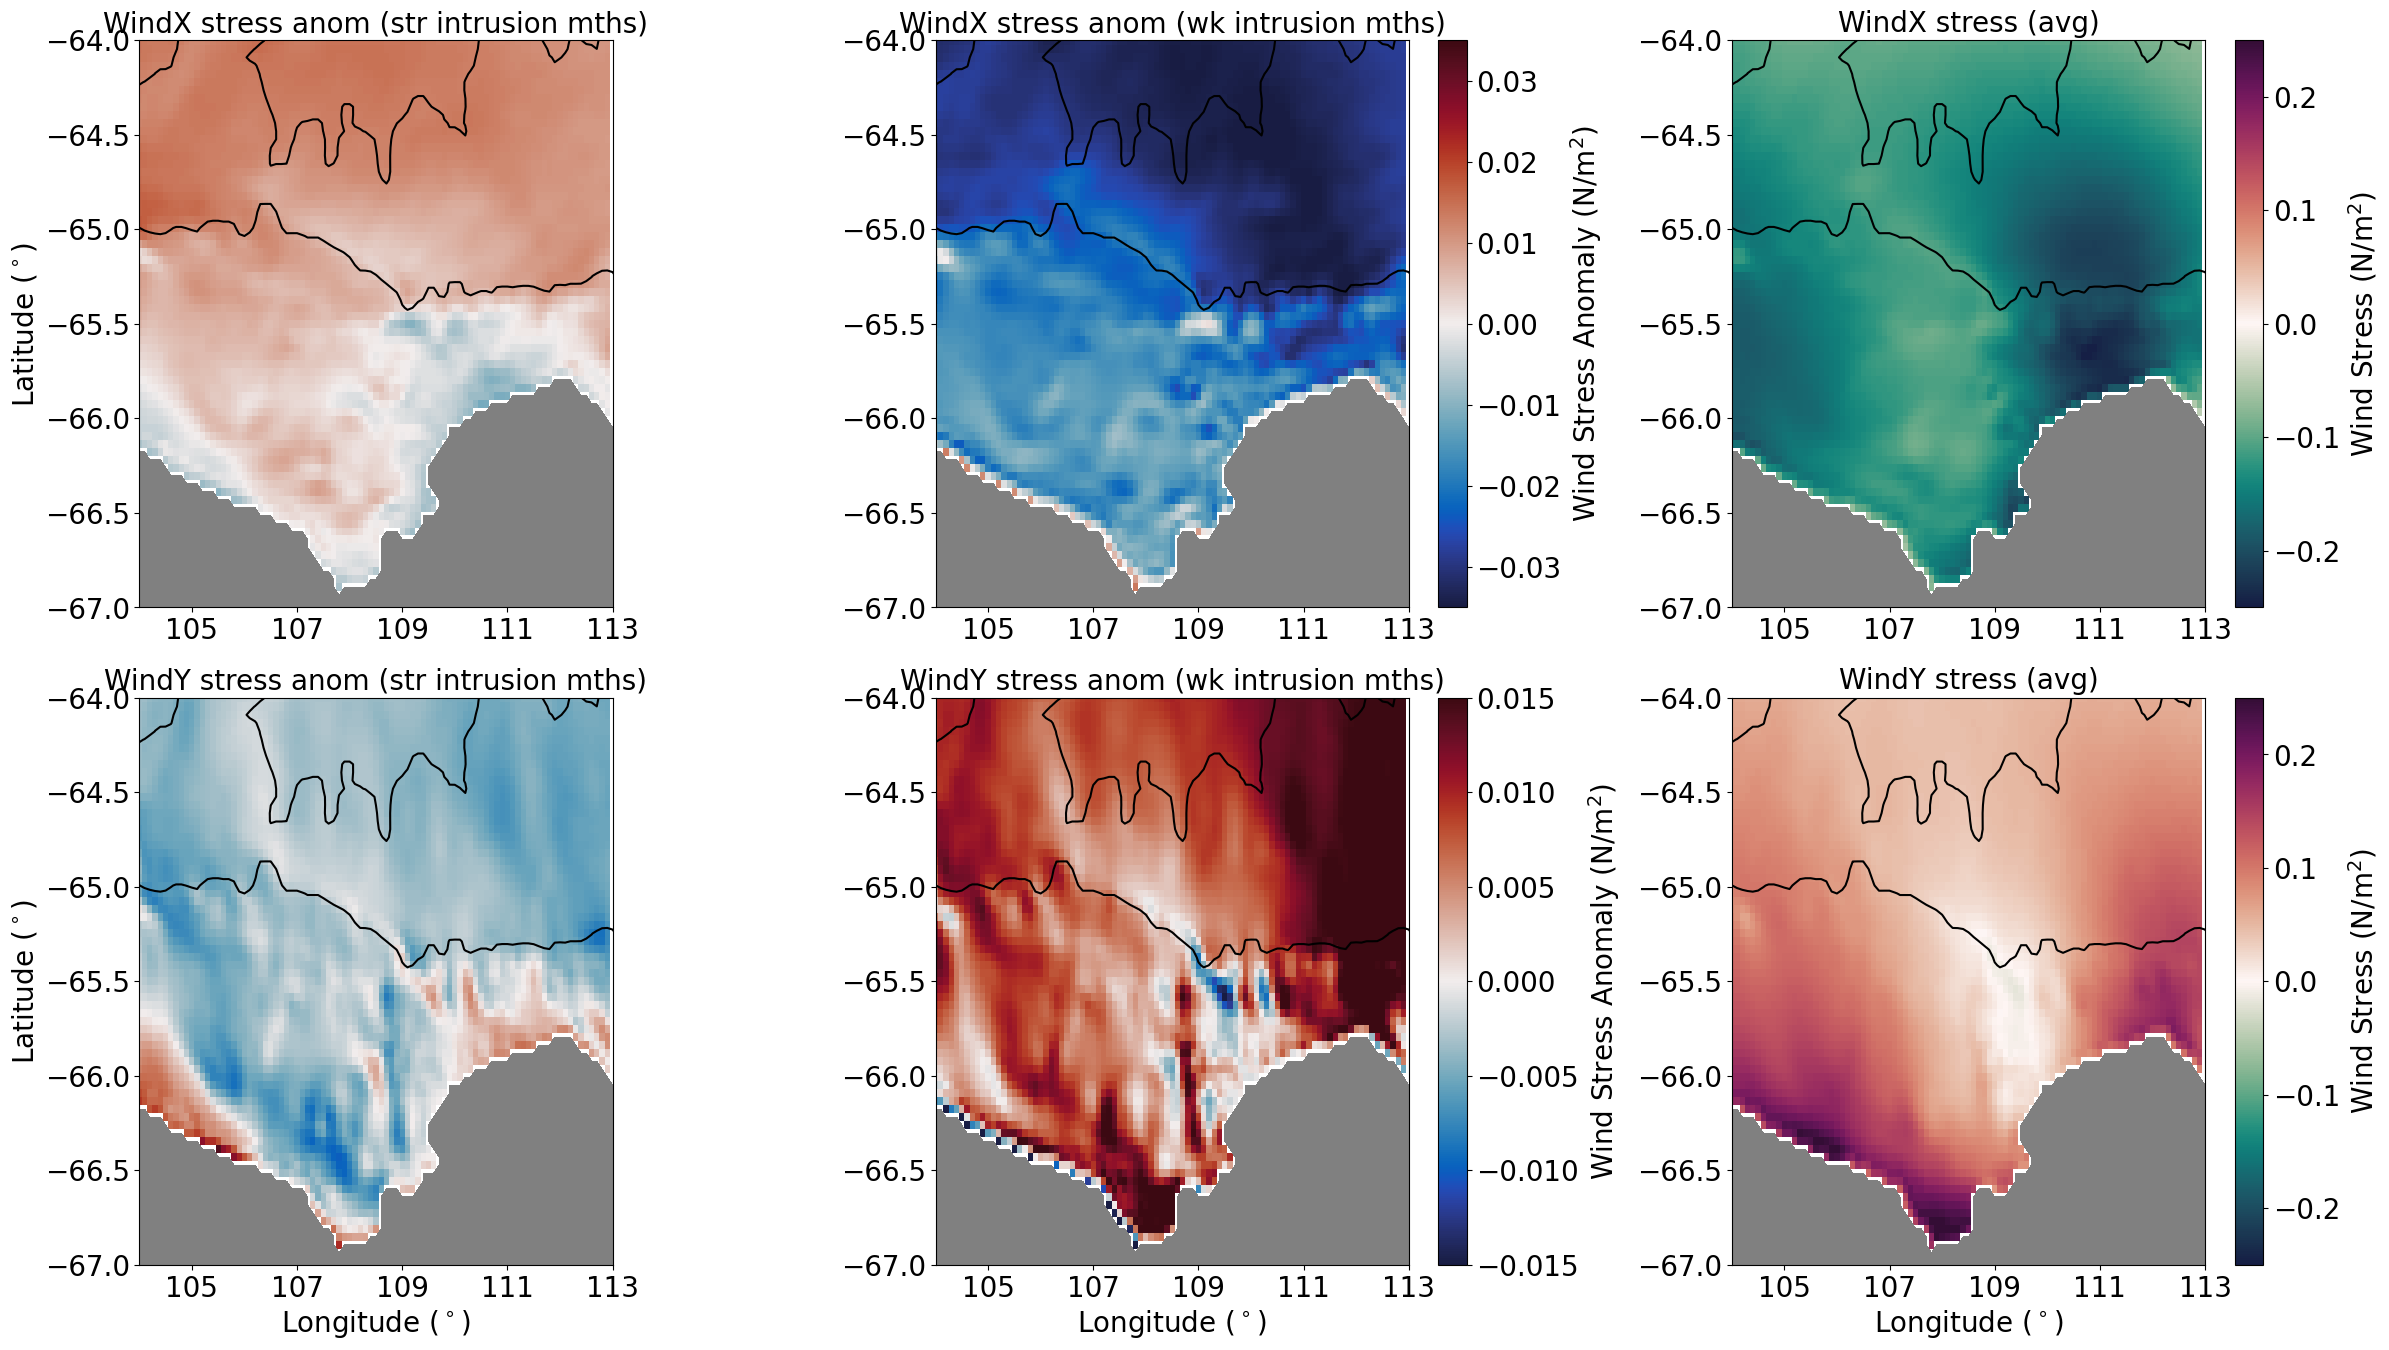

In [17]:
fontsize=20

fig=plt.figure(figsize=(24, 26))
fig.subplots_adjust(top=0.88)

wX_high = windX_high_avg_sh-windX_avg;
wX_low = windX_low_avg_sh-windX_avg;
wY_high = windY_high_avg_sh-windY_avg;
wY_low = windY_low_avg_sh-windY_avg;
ax0=plt.subplot(4,3,1) 
pc = plt.pcolormesh(wX_high.xu_ocean, wX_high.yu_ocean,wX_high,cmap = cmocean.cm.balance, 
                        vmin=-0.035,vmax=0.035)
plt.title('WindX stress anom (str intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
 # Add subplot indexes (a), b), c)) - first argument moves it horizontally, second argument moves it vertically
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0=plt.subplot(4,3,2) 
pc = plt.pcolormesh(wX_low.xu_ocean, wX_low.yu_ocean,wX_low,cmap = cmocean.cm.balance, 
                        vmin=-0.035,vmax=0.035)
plt.title('WindX stress anom (wk intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress Anomaly (N/m$^{2}$)', fontsize = 20,labelpad=5)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


ax0=plt.subplot(4,3,3)
pc = plt.pcolormesh(windX_avg.xu_ocean, windX_avg.yu_ocean,windX_avg,cmap = cmocean.cm.curl, 
                        vmin=-0.25,vmax=0.25) #ideal was -0.25 and 0.05
plt.title('WindX stress (avg)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress (N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,4) 
pc = plt.pcolormesh(wY_high.xu_ocean, wY_high.yu_ocean,wY_high,cmap = cmocean.cm.balance, 
                        vmin=-0.015,vmax=0.015) # ideal was -0.025 and 0.005
plt.title('WindY stress anom (str intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[6])

ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,5) 
pc = plt.pcolormesh(wY_low.xu_ocean, wY_low.yu_ocean,wY_low,cmap = cmocean.cm.balance, 
                        vmin=-0.015,vmax=0.015) # ideal was -0.025 and 0.005
plt.title('WindY stress anom (wk intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress Anomaly (N/m$^{2}$)', fontsize = 20,labelpad=5)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


ax0=plt.subplot(4,3,6) 
pc = plt.pcolormesh(windY_avg.xu_ocean, windY_avg.yu_ocean,windY_avg,cmap = cmocean.cm.curl, 
                        vmin=-0.25,vmax=0.25) #ideal was -0.05 and 0.25
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('WindY stress (avg)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress (N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

fig.tight_layout()

#save_results_to = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
#plt.savefig(save_results_to + 'WindStressAnom_fixed_limits_shifted.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

### Same as above, but putting the mean ahead of the anomaly plots as requested by the reviewer

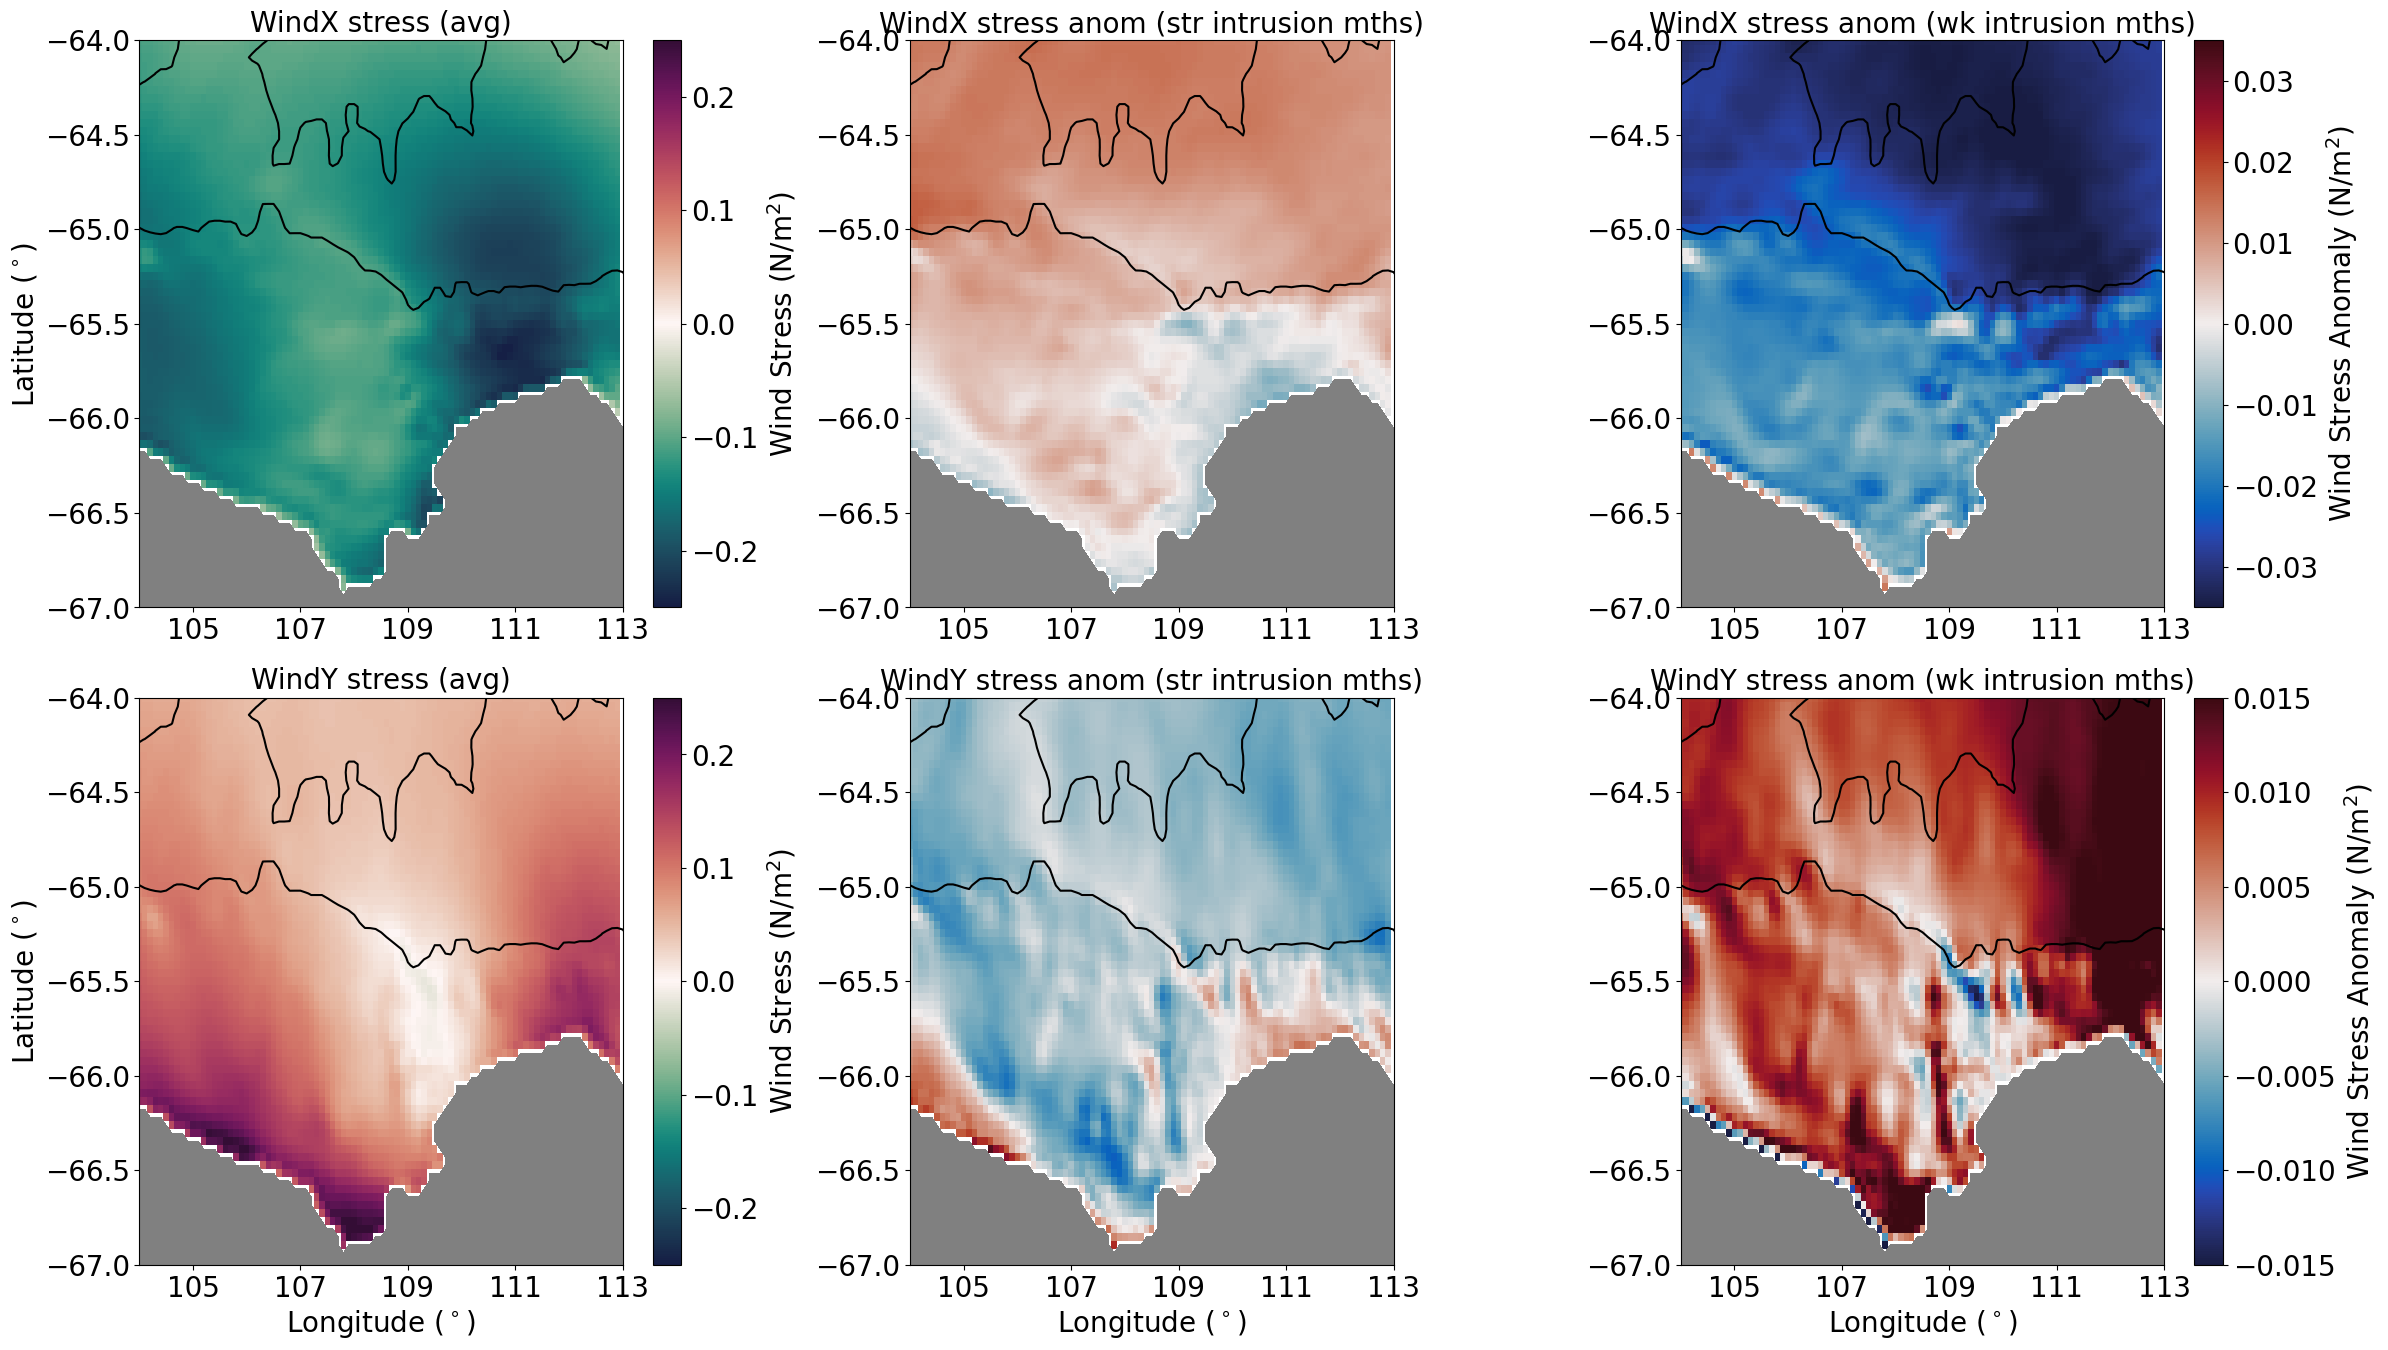

In [18]:
fontsize=20

fig=plt.figure(figsize=(24, 26))
fig.subplots_adjust(top=0.88)

wX_high = windX_high_avg_sh-windX_avg;
wX_low = windX_low_avg_sh-windX_avg;
wY_high = windY_high_avg_sh-windY_avg;
wY_low = windY_low_avg_sh-windY_avg;
ax0=plt.subplot(4,3,2) 
pc = plt.pcolormesh(wX_high.xu_ocean, wX_high.yu_ocean,wX_high,cmap = cmocean.cm.balance, 
                        vmin=-0.035,vmax=0.035)
plt.title('WindX stress anom (str intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
 # Add subplot indexes (a), b), c)) - first argument moves it horizontally, second argument moves it vertically
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0=plt.subplot(4,3,3) 
pc = plt.pcolormesh(wX_low.xu_ocean, wX_low.yu_ocean,wX_low,cmap = cmocean.cm.balance, 
                        vmin=-0.035,vmax=0.035)
plt.title('WindX stress anom (wk intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress Anomaly (N/m$^{2}$)', fontsize = 20,labelpad=5)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


ax0=plt.subplot(4,3,1)
pc = plt.pcolormesh(windX_avg.xu_ocean, windX_avg.yu_ocean,windX_avg,cmap = cmocean.cm.curl, 
                        vmin=-0.25,vmax=0.25) #ideal was -0.25 and 0.05
plt.title('WindX stress (avg)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude [$^\circ$E]',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress (N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,5) 
pc = plt.pcolormesh(wY_high.xu_ocean, wY_high.yu_ocean,wY_high,cmap = cmocean.cm.balance, 
                        vmin=-0.015,vmax=0.015) # ideal was -0.025 and 0.005
plt.title('WindY stress anom (str intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[6])

ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,6) 
pc = plt.pcolormesh(wY_low.xu_ocean, wY_low.yu_ocean,wY_low,cmap = cmocean.cm.balance, 
                        vmin=-0.015,vmax=0.015) # ideal was -0.025 and 0.005
plt.title('WindY stress anom (wk intrusion mths)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude [$^\circ$S]',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress Anomaly (N/m$^{2}$)', fontsize = 20,labelpad=5)
#cbar.set_label(r'(N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


ax0=plt.subplot(4,3,4) 
pc = plt.pcolormesh(windY_avg.xu_ocean, windY_avg.yu_ocean,windY_avg,cmap = cmocean.cm.curl, 
                        vmin=-0.25,vmax=0.25) #ideal was -0.05 and 0.25
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('WindY stress (avg)',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Wind Stress (N/m$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

fig.tight_layout()

save_results_to = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
plt.savefig(save_results_to + 'WindStressAnom_fixed_limits_shifted_meanAHEAD.png', dpi=120,bbox_inches='tight', pad_inches=0.1)